# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import resource
import psutil
import sys
from dotenv import load_dotenv

import seaborn as sns
import boto3
import ast
import json

from sklearn.preprocessing import MinMaxScaler
import scipy
import sklearn.preprocessing
from catboost import CatBoostClassifier, Pool

random_seed=0

%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'retina'

load_dotenv()

AWS_S3_ENDPOINT_URL = 'https://storage.yandexcloud.net'
AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY= os.getenv("AWS_SECRET_ACCESS_KEY")
S3_BUCKET_NAME = os.getenv('S3_BUCKET_NAME')

session = boto3.session.Session()
s3_client = session.client(
    service_name='s3',
    endpoint_url=AWS_S3_ENDPOINT_URL,
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY
)

def send_to_s3(filepath, filename, bucket):
    try:
        s3_client.upload_file(filename, bucket, f'{filepath}/{filename}')
        print('Успешно')
    except Exception as ex:
        print(f'Ошибка {ex}')


def show_memory_usage():
    globals_dict = globals()
    sizes = {name: sys.getsizeof(obj) for name, obj in globals_dict.items() if not name.startswith('_')}
    sorted_sizes = sorted(sizes.items(), key=lambda x: -x[1])
    
    for name, size in sorted_sizes[:15]:  # Топ-10 самых тяжелых объектов
        print(f"{name}: {size/1024**2:.2f} MB")

    print(f"Доступно памяти: {psutil.virtual_memory().total/1e9:.2f} GB")
    print(f"Используется: {psutil.virtual_memory().used/1e9:.2f} GB")

### создадим функцию определения популярности, чтобы избежать переиспользования кода
def get_most_popular(type):
    most_popular = pd.DataFrame(interactions['track_id'].value_counts()
                            ).merge(catalog_names, left_on='track_id', right_on='id', 
                            how='inner').sort_values('count', ascending=False)
    if type == 'track':
        pass
    else:
        most_popular = most_popular.merge(tracks,left_on = 'id', right_on='track_id',
                        how = 'inner').explode(str(type)+'s')[str(type)+'s'].value_counts()
        most_popular = most_popular.reset_index()
        most_popular.columns = ['id', 'count']  
        most_popular = most_popular.merge(catalog_names[catalog_names['type'] == type],
                                        #   left_on = 'id', right_on='track_id',
                                        on = 'id', how = 'inner')
    return most_popular

large_df = pd.DataFrame({'col': range(10**6)})
show_memory_usage()

large_df: 7.63 MB
MinMaxScaler: 0.00 MB
CatBoostClassifier: 0.00 MB
Pool: 0.00 MB
open: 0.00 MB
load_dotenv: 0.00 MB
send_to_s3: 0.00 MB
show_memory_usage: 0.00 MB
get_most_popular: 0.00 MB
AWS_SECRET_ACCESS_KEY: 0.00 MB
S3_BUCKET_NAME: 0.00 MB
AWS_S3_ENDPOINT_URL: 0.00 MB
AWS_ACCESS_KEY_ID: 0.00 MB
In: 0.00 MB
plt: 0.00 MB
Доступно памяти: 33.65 GB
Используется: 2.86 GB


<b>Комментарий от ревьюера v1</b>
<div class="alert alert-block alert-success">
✔️ Импорты сделаны, отлично! 
</div>

<div class="alert alert-warning">
    
⚠️ Для удобной работы с кодом советую придерживаться правил оформления PEP8.
    
В соответствии с этими правилами импорты должны быть сгруппированы в следующем порядке:
* импорты из стандартной библиотеки
* импорты сторонних библиотек
* импорты модулей текущего проекта

Рекомендуется добавлять пустую строку между каждой группой импортов.

Подробные правила можно посмотреть: https://pythonworld.ru/osnovy/pep-8-rukovodstvo-po-napisaniyu-koda-na-python.html#section-8
</div>

<div class="alert alert-warning">

⚠️ `SEED` стоит зафиксировать в самом начале. Это позволит тебе добиваться воспроизводимости результатов. 

</div>

<div class="alert alert-info">
<h2> Комментарий студента</h2>

Привет! Поправил немного импорты и указал seed.


</div>


<b>Комментарий от ревьюера v2</b>

<div class="alert alert-block alert-success">
✔️ Отлично, спасибо!
</div>

# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [26]:
tracks = pd.read_parquet("data/tracks.parquet")
catalog_names = pd.read_parquet("data/catalog_names.parquet")
interactions = pd.read_parquet("data/interactions.parquet")
show_memory_usage()

interactions: 5520.23 MB
tracks: 350.95 MB
catalog_names: 263.71 MB
large_df: 7.63 MB
MinMaxScaler: 0.00 MB
CatBoostClassifier: 0.00 MB
Pool: 0.00 MB
Out: 0.00 MB
In: 0.00 MB
open: 0.00 MB
load_dotenv: 0.00 MB
send_to_s3: 0.00 MB
show_memory_usage: 0.00 MB
get_most_popular: 0.00 MB
AWS_SECRET_ACCESS_KEY: 0.00 MB
Доступно памяти: 33.65 GB
Используется: 22.02 GB


# Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

In [27]:
catalog_names.head()

,id,type,name
0,3,album,Taller Children
1,12,album,Wild Young Hearts
2,13,album,Lonesome Crow
3,17,album,Graffiti Soul
4,26,album,Blues Six Pack


In [28]:
interactions.head()

,user_id,track_id,track_seq,started_at
0,0,99262,1,2022-07-17
1,0,589498,2,2022-07-19
2,0,590262,3,2022-07-21
3,0,590303,4,2022-07-22
4,0,590692,5,2022-07-22


In [29]:
catalog_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1812471 entries, 0 to 1812470
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   id      int64 
 1   type    object
 2   name    object
dtypes: int64(1), object(2)
memory usage: 41.5+ MB


In [30]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222629898 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 5.4 GB


Проведем анализ пустых значений

In [31]:
print(tracks.isnull().sum().sort_values(ascending=False))
print('-----------')
print(catalog_names.isnull().sum().sort_values(ascending=False))
print('-----------')
print(interactions.isnull().sum().sort_values(ascending=False))

track_id    0
albums      0
artists     0
genres      0
dtype: int64
-----------
id      0
type    0
name    0
dtype: int64
-----------
user_id       0
track_id      0
track_seq     0
started_at    0
dtype: int64


In [32]:
# ### удаляем пустые массивы
tracks = tracks[(tracks['albums'].str.len() != 0) & (tracks['artists'].str.len() != 0) &
       (tracks['genres'].str.len() != 0)]
tracks

,track_id,albums,artists,genres
0,26,"[3, 2490753]",[16],"[11, 21]"
1,38,"[3, 2490753]",[16],"[11, 21]"
2,135,"[12, 214, 2490809]",[84],[11]
3,136,"[12, 214, 2490809]",[84],[11]
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11]
...,...,...,...,...
999995,101478482,[21399811],[5540395],"[3, 75]"
999996,101490148,[21403052],[9078726],"[11, 20]"
999997,101493057,[21403883],[11865715],"[44, 75]"
999998,101495927,[21404975],[4462686],"[3, 75]"


In [33]:
# ### для экономии памяти сохраним очищенный датасет, чтобы в дальнейшем читать уже его
# tracks.to_parquet('data/tracks_clean.parquet')
del tracks
tracks = pd.read_parquet('data/tracks_clean.parquet')


Проверка на наличие дубликатов

In [34]:
print(tracks['track_id'].duplicated().sum())
print(catalog_names['id'].duplicated().sum())
print(interactions['user_id'].duplicated().sum())

0
35774
221256677


In [12]:
catalog_names[catalog_names['id'].duplicated(keep=False)].sort_values(by=['id'])

,id,type,name
812308,3,genre,rusrap
0,3,album,Taller Children
812309,4,genre,postrock
658724,4,artist,Kenny Dorham
658725,5,artist,Max Roach
...,...,...,...
1141114,21321251,track,Lady in Red
1141142,21327491,track,Waiting Here
658146,21327491,album,Lay With Me The Ultimate Fantasy Playlist
658501,21388828,album,Serata Sanremo


In [24]:
catalog_names[catalog_names[['id', 'type']].duplicated(keep=False)].sort_values(by=['id'])

,id,type,name


Как мы видим, дубли в catalog_names присутствуют только в качестве id. При привязке к типу каталога дублей нет. Считаю, что нет необходимости удалять такие дубли

In [14]:
interactions[interactions[['user_id', 'track_id']].duplicated(keep=False)].sort_values(by=['user_id', 'track_id'])

,user_id,track_id,track_seq,started_at


Аналогичная ситуация по взаимодействиям. Нет повторяющихся взаимодействий "пользователь-трек"

Некорректные поля

In [35]:
catalog_names[catalog_names['name'].str.len()==1]

,id,type,name
744,1756,album,R
3864,8285,album,7
6996,18121,album,9
7640,21076,album,i
8306,23526,album,9
...,...,...,...
1802952,96311572,track,О
1803916,96687494,track,N
1806190,97580726,track,U
1808730,98756838,track,I


Не нашел на Яндекс Музыке таких исполнителей и альбомов. Можно очистить

In [36]:
catalog_names = catalog_names[catalog_names['name'].str.len()!=1]
catalog_names.head()

,id,type,name
0,3,album,Taller Children
1,12,album,Wild Young Hearts
2,13,album,Lonesome Crow
3,17,album,Graffiti Soul
4,26,album,Blues Six Pack


In [3]:
# ### для экономии памяти сохраним очищенный датасет, чтобы в дальнейшем читать уже его
# catalog_names.to_parquet('data/catalog_names_clean.parquet')
# del catalog_names
catalog_names = pd.read_parquet('data/catalog_names_clean.parquet')

In [5]:
catalog_names.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1811437 entries, 0 to 1812470
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   id      int64 
 1   type    object
 2   name    object
dtypes: int64(1), object(2)
memory usage: 55.3+ MB


In [15]:
catalog_names['type'] = catalog_names['type'].astype('category')
catalog_names.info()
catalog_names.to_parquet('data/catalog_names_clean.parquet')

<class 'pandas.core.frame.DataFrame'>
Index: 1811437 entries, 0 to 1812470
Data columns (total 3 columns):
 #   Column  Dtype   
---  ------  -----   
 0   id      int64   
 1   type    category
 2   name    object  
dtypes: category(1), int64(1), object(1)
memory usage: 43.2+ MB


In [9]:
# ### для экономии памяти сохраним очищенный датасет, чтобы в дальнейшем читать уже его
# interactions.to_parquet('data/interactions_clean.parquet')
# del interactions
interactions = pd.read_parquet('data/interactions_clean.parquet')
show_memory_usage()


interactions: 5520.23 MB
catalog_names: 171.87 MB
large_df: 7.63 MB
MinMaxScaler: 0.00 MB
CatBoostClassifier: 0.00 MB
Pool: 0.00 MB
Out: 0.00 MB
In: 0.00 MB
open: 0.00 MB
load_dotenv: 0.00 MB
send_to_s3: 0.00 MB
show_memory_usage: 0.00 MB
get_most_popular: 0.00 MB
AWS_SECRET_ACCESS_KEY: 0.00 MB
S3_BUCKET_NAME: 0.00 MB
Доступно памяти: 33.65 GB
Используется: 14.43 GB


In [13]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222629898 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 5.4 GB


# Выводы

Приведём выводы по первому знакомству с данными:
- есть ли с данными явные проблемы,
- какие корректирующие действия (в целом) были предприняты.

Крупных проблем с данными не обнаружено. Среди обнаруженных и исправленных проблем: <br>
- Пустые массивы в tracks;
- Некорректные имена каталогов

Явных и значительных проблем в данных не обнаружил. <br>
Были удалены пустые и некорректные записи, а также записи в названии которых один символ. Проверка по по поиску некоторых вышеописанных композиций в Яндекс Музыке не принесла результатов. Так как число таких конмпозиций также незначительно - принял решение очистить эти данные.

<b>Комментарий от ревьюера v1</b>

<div class="alert alert-block alert-success">
✔️ Первичный анализ данных произведен, отлично!
</div>

<div class="alert alert-warning">
В связи с большим объемом занимаемой оперативной памяти будет здорово подумать над оптимизацией типов данных.
    
Например, для всех ли столбцов тип object необходим)? Для больших датасетов оптимизация типов данных позволяет сократить объём занимаемой оперативной памяти.

Подробнее: https://towardsdatascience.com/seven-killer-memory-optimization-techniques-every-pandas-user-should-know-64707348ab20
</div>

<div class="alert alert-info">
<h2> Комментарий студента</h2>

Да, действительно, перевел тип данных столбца type в датафрейме catalog_names из object в category.


</div>


<b>Комментарий от ревьюера v2</b>

<div class="alert alert-block alert-success">
✔️ Отлично, так ты сэкономишь немного памяти.
</div>

# === ЭТАП 2 ===

# EDA

In [2]:
tracks = pd.read_parquet('data/tracks_clean.parquet')
catalog_names = pd.read_parquet('data/catalog_names_clean.parquet')
interactions = pd.read_parquet("data/interactions_clean.parquet")
show_memory_usage()

interactions: 5520.23 MB
tracks: 351.76 MB
catalog_names: 277.40 MB
large_df: 7.63 MB
MinMaxScaler: 0.00 MB
CatBoostClassifier: 0.00 MB
Pool: 0.00 MB
open: 0.00 MB
load_dotenv: 0.00 MB
send_to_s3: 0.00 MB
show_memory_usage: 0.00 MB
get_most_popular: 0.00 MB
In: 0.00 MB
AWS_SECRET_ACCESS_KEY: 0.00 MB
S3_BUCKET_NAME: 0.00 MB
Доступно памяти: 33.65 GB
Используется: 13.97 GB


Распределение количества прослушанных треков.

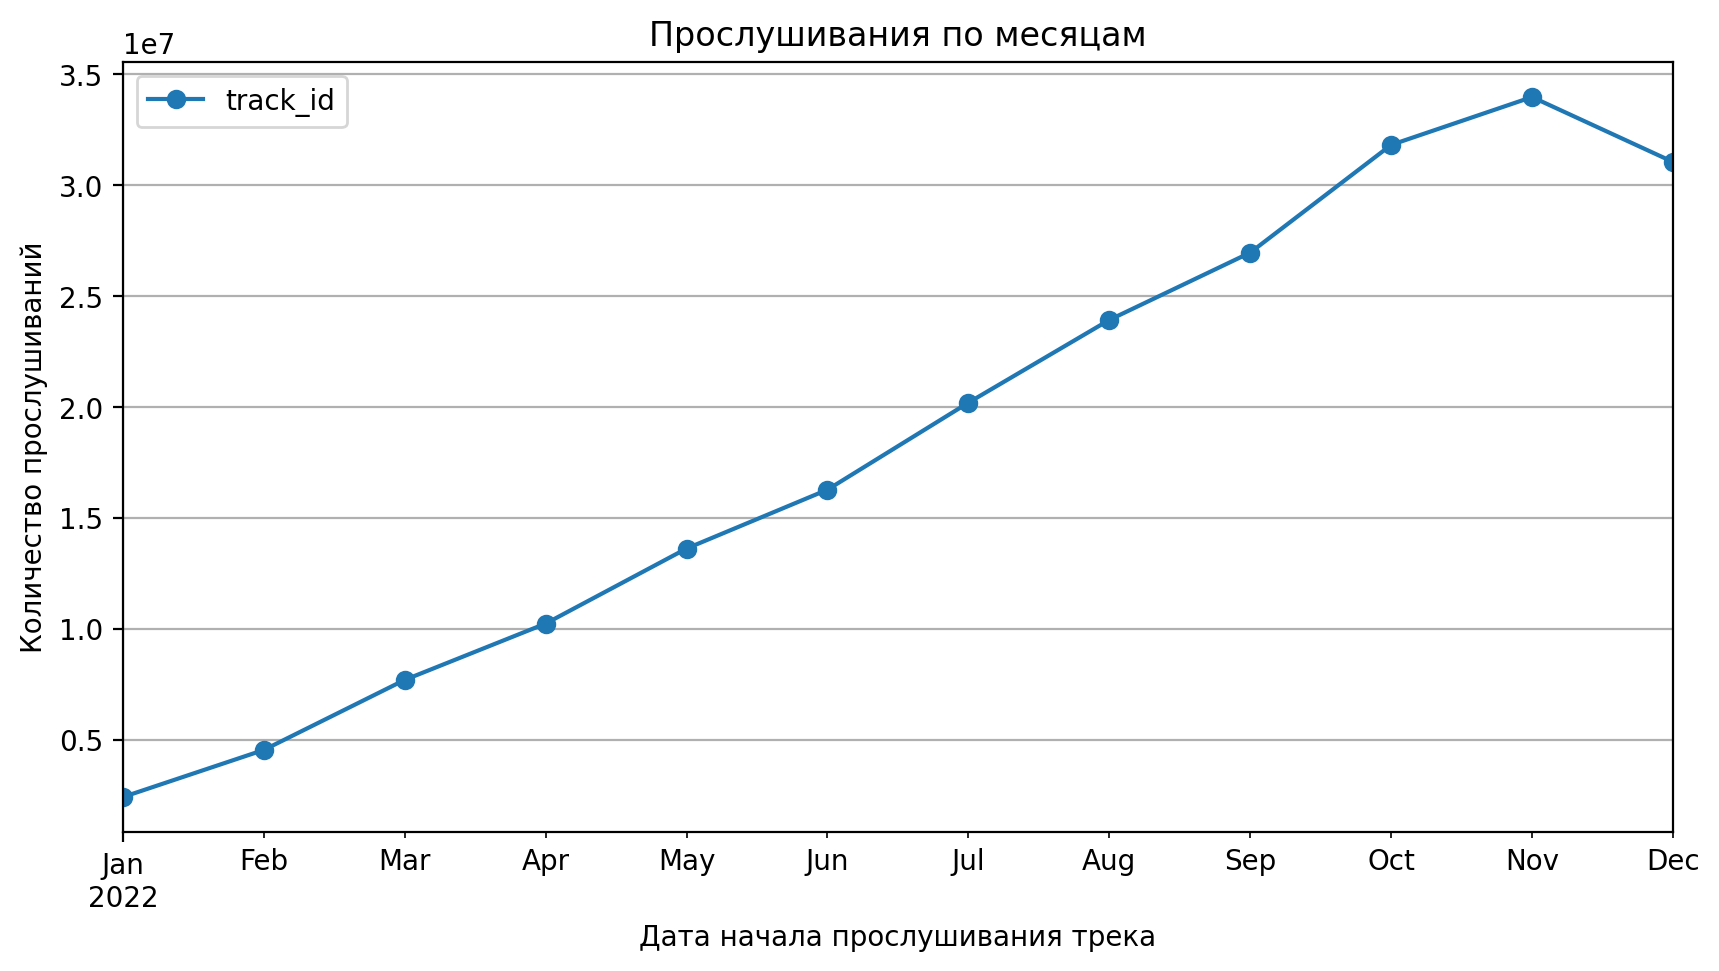

In [3]:
interactions['month'] = pd.to_datetime(interactions['started_at'], unit='s').dt.to_period('M') 
monthly_listened = interactions.groupby('month').agg({'track_id' : 'count'})
monthly_listened.plot(kind='line', figsize=(10, 5), marker='o')
plt.title('Прослушивания по месяцам')
plt.xlabel('Дата начала прослушивания трека')
plt.ylabel('Количество прослушиваний')
plt.grid()
plt.show()

<b>Комментарий от ревьюера v1</b>
<div class="alert alert-block alert-success">

✔️ Отличная визуализация, оси подписаны, отлично!
</div>

Наиболее популярные треки

In [5]:
get_most_popular('track')[:10]

,count,id,type,name
0,111062,53404,track,Smells Like Teen Spirit
1,106921,33311009,track,Believer
2,101924,178529,track,Numb
3,99490,35505245,track,I Got Love
4,86670,65851540,track,Юность
5,86246,24692821,track,Way Down We Go
6,85886,32947997,track,Shape of You
7,85244,51241318,track,In The End
8,85042,795836,track,Shape Of My Heart
9,84748,45499814,track,Life


<b>Комментарий от ревьюера v1</b>
<div class="alert alert-block alert-success">

✔️ Выглядит логично!
</div>

Наиболее популярные жанры

In [6]:
get_most_popular('genre')[:10]

,id,count,type,name
0,11,171702,genre,pop
1,75,129698,genre,rap
2,102,124158,genre,allrock
3,68,115774,genre,electronics
4,47,74948,genre,metal
5,3,66114,genre,rusrap
6,44,61088,genre,foreignrap
7,14,59072,genre,rock
8,16,52138,genre,dance
9,20,47058,genre,ruspop


Треки, которые никто не прослушал

In [7]:
# Доля невостребованных треков
total_tracks = tracks['track_id'].nunique()
active_tracks = interactions['track_id'].nunique()
print(f"Доля треков без прослушиваний: {(total_tracks - active_tracks)/total_tracks*100:.1f}%")

# Доля пользователей c одним прослушиванием
one_time_users = (interactions['user_id'].value_counts() == 1).sum()
print(f"Доля пользователей с 1 прослушиванием: {one_time_users/interactions['user_id'].nunique()*100:.1f}%")

Доля треков без прослушиваний: -1.9%
Доля пользователей с 1 прослушиванием: 0.1%


# Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

In [8]:
interactions.drop(columns='month', inplace=True)

In [9]:
show_memory_usage()

interactions: 5520.23 MB
tracks: 351.76 MB
catalog_names: 277.40 MB
large_df: 7.63 MB
MinMaxScaler: 0.00 MB
CatBoostClassifier: 0.00 MB
Pool: 0.00 MB
Out: 0.00 MB
monthly_listened: 0.00 MB
In: 0.00 MB
open: 0.00 MB
load_dotenv: 0.00 MB
send_to_s3: 0.00 MB
show_memory_usage: 0.00 MB
get_most_popular: 0.00 MB
Доступно памяти: 33.65 GB
Используется: 12.73 GB


Удаляем треки с малым количеством прослушиваний

In [29]:
# Считаем количество прослушиваний по каждому треку
track_play_counts = interactions['track_id'].value_counts().rename('play_count')

# Фильтруем треки с >10 прослушиваний
popular_tracks = track_play_counts[track_play_counts > 10].index

# Оставляем только строки с популярными треками
filtered_interactions = interactions[interactions['track_id'].isin(popular_tracks)].copy()

# Проверяем результат
print(f"Было строк: {len(interactions)}")
print(f"Осталось строк: {len(filtered_interactions)}")
print(f"Уникальных треков осталось: {filtered_interactions['track_id'].nunique()}")

Было строк: 222629898
Осталось строк: 220324055
Уникальных треков осталось: 678502


<b>Комментарий от ревьюера v1</b>
<div class="alert alert-block alert-success">

✔️ ОК!
</div>

In [30]:
interactions = filtered_interactions
del filtered_interactions
del popular_tracks
del track_play_counts
show_memory_usage()

interactions: 5463.05 MB
tracks: 351.76 MB
catalog_names: 277.40 MB
large_df: 7.63 MB
In: 0.00 MB
open: 0.00 MB
load_dotenv: 0.00 MB
send_to_s3: 0.00 MB
show_memory_usage: 0.00 MB
get_most_popular: 0.00 MB
AWS_SECRET_ACCESS_KEY: 0.00 MB
S3_BUCKET_NAME: 0.00 MB
AWS_S3_ENDPOINT_URL: 0.00 MB
AWS_ACCESS_KEY_ID: 0.00 MB
logging: 0.00 MB
Доступно памяти: 33.65 GB
Используется: 12.54 GB


In [31]:
# собираем словари, для дальнейшего удобства
id_mappings = {
    'album': catalog_names[catalog_names['type'] == 'album'].set_index('id')['name'].to_dict(),
    'artist': catalog_names[catalog_names['type'] == 'artist'].set_index('id')['name'].to_dict(),
    'genre': catalog_names[catalog_names['type'] == 'genre'].set_index('id')['name'].to_dict(),
    'track': catalog_names[catalog_names['type'] == 'track'].set_index('id')['name'].to_dict()
}

def decode_with_type(ids, element_type):
    if isinstance(ids, str):
        ids = ast.literal_eval(ids)
    return {k: id_mappings[element_type].get(k, f'Unknown_{k}') for k in ids}

# Применяем к каждому столбцу с учетом типа
items = tracks.copy()
items['albums'] = tracks['albums'].apply(lambda x: decode_with_type(x, 'album'))
items['artists'] = tracks['artists'].apply(lambda x: decode_with_type(x, 'artist'))
items['genres'] = tracks['genres'].apply(lambda x: decode_with_type(x, 'genre'))
items['track_name'] = tracks['track_id'].map(id_mappings['track'])

items.head()

,track_id,albums,artists,genres,track_name
0,26,"{3: 'Taller Children', 2490753: 'Taller Childr...",{16: 'Elizabeth & the Catapult'},"{11: 'pop', 21: 'folk'}",Complimentary Me
1,38,"{3: 'Taller Children', 2490753: 'Taller Childr...",{16: 'Elizabeth & the Catapult'},"{11: 'pop', 21: 'folk'}",Momma's Boy
2,135,"{12: 'Wild Young Hearts', 214: 'Wild Young Hea...",{84: 'Noisettes'},{11: 'pop'},Atticus
3,136,"{12: 'Wild Young Hearts', 214: 'Wild Young Hea...",{84: 'Noisettes'},{11: 'pop'},24 Hours
4,138,"{12: 'Wild Young Hearts', 214: 'Wild Young Hea...",{84: 'Noisettes'},{11: 'pop'},Don't Upset The Rhythm (Go Baby Go)


In [32]:
# Преобразуем словари с числовыми ключами в строковые, так как при сохранении в parquet с числовыми ключами появляется ошибка
def convert_dict_keys_to_str(d):
    if isinstance(d, dict):
        return {str(k): v for k, v in d.items()}
    return d

items['albums'] = items['albums'].apply(convert_dict_keys_to_str)
items['artists'] = items['artists'].apply(convert_dict_keys_to_str)
items['genres'] = items['genres'].apply(convert_dict_keys_to_str)

items['albums'] = items['albums'].apply(lambda x: json.dumps(x, ensure_ascii=False) 
                                        if isinstance(x, dict) else x)
items['artists'] = items['artists'].apply(lambda x: json.dumps(x, ensure_ascii=False) 
                                        if isinstance(x, dict) else x)
items['genres'] = items['genres'].apply(lambda x: json.dumps(x, ensure_ascii=False) 
                                        if isinstance(x, dict) else x)

items.head()

,track_id,albums,artists,genres,track_name
0,26,"{""3"": ""Taller Children"", ""2490753"": ""Taller Ch...","{""16"": ""Elizabeth & the Catapult""}","{""11"": ""pop"", ""21"": ""folk""}",Complimentary Me
1,38,"{""3"": ""Taller Children"", ""2490753"": ""Taller Ch...","{""16"": ""Elizabeth & the Catapult""}","{""11"": ""pop"", ""21"": ""folk""}",Momma's Boy
2,135,"{""12"": ""Wild Young Hearts"", ""214"": ""Wild Young...","{""84"": ""Noisettes""}","{""11"": ""pop""}",Atticus
3,136,"{""12"": ""Wild Young Hearts"", ""214"": ""Wild Young...","{""84"": ""Noisettes""}","{""11"": ""pop""}",24 Hours
4,138,"{""12"": ""Wild Young Hearts"", ""214"": ""Wild Young...","{""84"": ""Noisettes""}","{""11"": ""pop""}",Don't Upset The Rhythm (Go Baby Go)


# Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

In [33]:
del tracks
show_memory_usage()

interactions: 5463.05 MB
items: 466.29 MB
catalog_names: 277.40 MB
large_df: 7.63 MB
In: 0.00 MB
Out: 0.00 MB
id_mappings: 0.00 MB
open: 0.00 MB
load_dotenv: 0.00 MB
send_to_s3: 0.00 MB
show_memory_usage: 0.00 MB
get_most_popular: 0.00 MB
decode_with_type: 0.00 MB
convert_dict_keys_to_str: 0.00 MB
AWS_SECRET_ACCESS_KEY: 0.00 MB
Доступно памяти: 33.65 GB
Используется: 9.88 GB


In [34]:
unseen_tracks = set(interactions["track_id"]) - set(items["track_id"])
print(f"Найдено {len(unseen_tracks)} треков в interactions, отсутствующих в items")

Найдено 9689 треков в interactions, отсутствующих в items


In [36]:
interactions = interactions[interactions['track_id'].isin(items["track_id"])]
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 219944219 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 5.3 GB


In [37]:
# items.to_parquet("data/items.par")
items.to_parquet('data/items.parquet', engine='fastparquet', index=False)
interactions.to_parquet("data/events.parquet")
send_to_s3('recsys/data/', 'data/items.parquet', S3_BUCKET_NAME)
send_to_s3('recsys/data/', 'data/events.parquet', S3_BUCKET_NAME)

Успешно
Успешно


# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

Необходимо перезапустить kernel и выполнить первую ячейку и двигаться по ячейкам ниже

# === ЭТАП 3 ===

# Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

In [2]:
items = pd.read_parquet('data/items.parquet')
events = pd.read_parquet("data/events.parquet")
show_memory_usage()

events: 5453.63 MB
items: 458.80 MB
large_df: 7.63 MB
MinMaxScaler: 0.00 MB
CatBoostClassifier: 0.00 MB
Pool: 0.00 MB
open: 0.00 MB
load_dotenv: 0.00 MB
send_to_s3: 0.00 MB
show_memory_usage: 0.00 MB
get_most_popular: 0.00 MB
In: 0.00 MB
AWS_SECRET_ACCESS_KEY: 0.00 MB
S3_BUCKET_NAME: 0.00 MB
AWS_S3_ENDPOINT_URL: 0.00 MB
Доступно памяти: 33.65 GB
Используется: 14.75 GB


# Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

In [3]:
# зададим точку разбиения согласно заданию
train_test_global_time_split_date = pd.to_datetime("2022-12-16").date()

train_test_global_time_split_idx = events["started_at"].dt.date < train_test_global_time_split_date
events_train = events[train_test_global_time_split_idx]
events_test = events[~train_test_global_time_split_idx]

# количество пользователей в train и test
users_train = events_train["user_id"].drop_duplicates()
users_test = events_test["user_id"].drop_duplicates()
# количество пользователей, которые есть и в train, и в test
common_users = set(users_train) & set(users_test)

print(len(users_train), len(users_test), len(common_users))

# «Холодные» пользователи — те, которые есть в test, но отсутствуют в train. 
# Это соответствует хронологическому порядку, в котором и работает рекомендательная система.
cold_users = set(users_test.unique()) - set(users_train.unique())

print(len(cold_users))

1341439 778291 747524
30767


<b>Комментарий от ревьюера v1</b>

<div class="alert alert-block alert-success">
    
✔️ Отлично, выборки train / test сформированы. 

Выборки train / test можно получать несколькими способами (см. картинку ниже). Я тебе бы рекомендовал разбиение на train/test по времени.
</div>

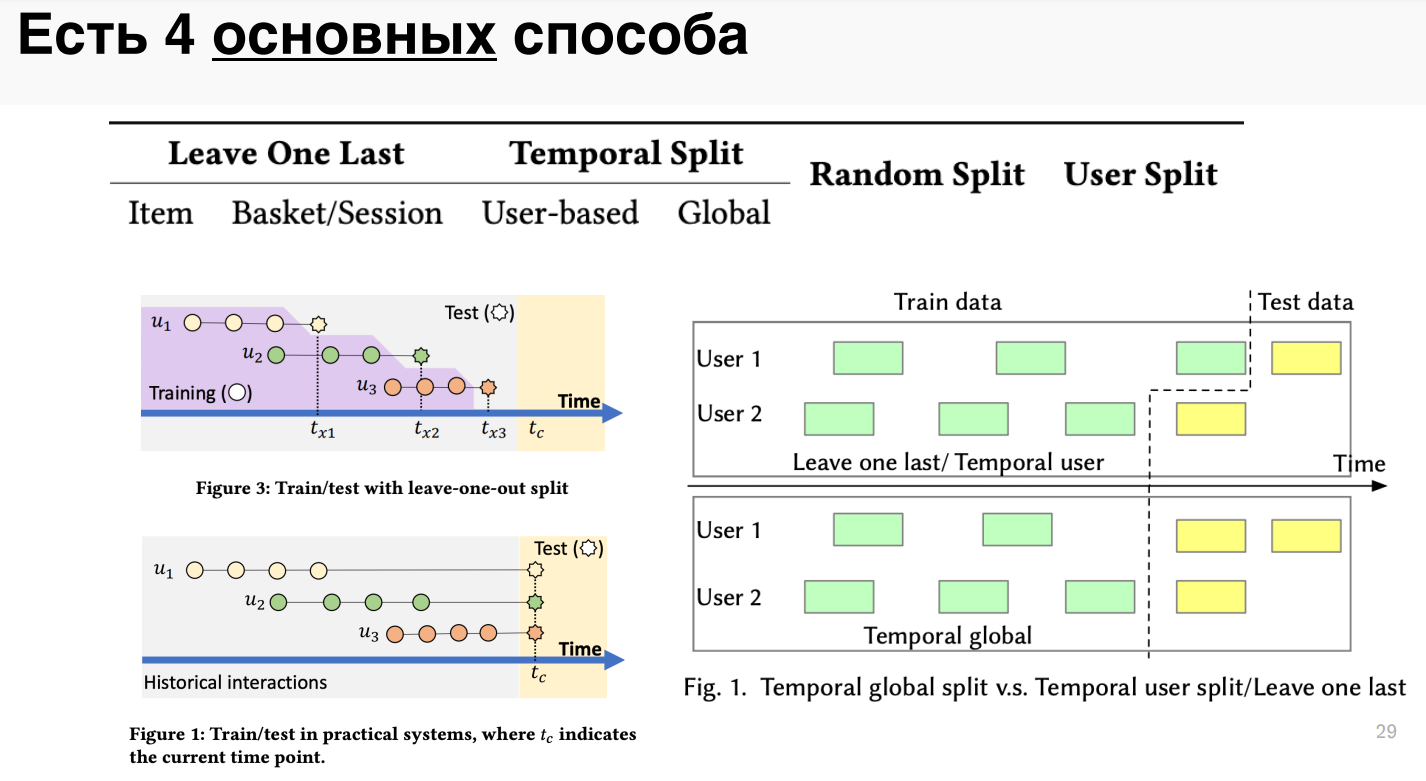

[Ссылка на картинку](https://disk.yandex.ru/i/L6hBTf6KLYRa-g)

<div class="alert alert-info">
<h2> Комментарий студента</h2>

Тут не совсем понял, так как разбивал выборку по времени.

</div>


<b>Комментарий от ревьюера v2</b>

<div class="alert alert-block alert-success">
✔️ Ты правильно сделал разбиение по времени! Есть другие способы разбиения, я привожу их варианты.
</div>

# Топ популярных

Рассчитаем рекомендации как топ популярных.

In [7]:
events_train['track_id'].value_counts()

track_id
53404        110026
33311009     101076
178529       100866
35505245      95523
24692821      84153
              ...  
96201253          1
90289228          1
93929317          1
98271681          1
100845793         1
Name: count, Length: 668807, dtype: int64

In [9]:
events_train.groupby('track_id').agg(users=("user_id", "nunique")).reset_index()

,track_id,users
0,135,16
1,138,17
2,140,24
3,141,342
4,143,18
...,...,...
668802,101458360,8
668803,101476180,17
668804,101490148,28
668805,101495927,7


In [11]:
item_popularity = pd.DataFrame(events_train['track_id'].value_counts() ### исправил тут
                            ).merge(items, on='track_id',
                            how='inner').sort_values('count', ascending=False)

item_popularity = pd.merge(item_popularity, events_train.groupby('track_id').agg(users=("user_id", "nunique"), ### и тут
                            avg_rating=("track_seq", "mean")).reset_index())

item_popularity.head()

,track_id,count,albums,artists,genres,track_name,users,avg_rating
0,53404,110026,"{""4367"": ""Nevermind"", ""89708"": ""Nirvana"", ""294...","{""9262"": ""Nirvana""}","{""13"": ""alternative"", ""14"": ""rock"", ""102"": ""al...",Smells Like Teen Spirit,110026,17.389681
1,33311009,101076,"{""4440454"": ""Shape Of Pop"", ""4456609"": ""NOW Th...","{""675068"": ""Imagine Dragons""}","{""14"": ""rock"", ""102"": ""allrock""}",Believer,101076,225.144396
2,178529,100866,"{""18113"": ""Meteora"", ""21924"": ""Meteora"", ""2194...","{""36800"": ""Linkin Park""}","{""41"": ""numetal"", ""47"": ""metal""}",Numb,100866,38.155781
3,35505245,95523,"{""4431303"": ""I Got Love"", ""20559909"": ""I Got L...","{""4611844"": ""Miyagi & Эндшпиль"", ""588511"": ""Ре...","{""3"": ""rusrap"", ""75"": ""rap""}",I Got Love,95523,155.747914
4,24692821,84153,"{""2888516"": ""Way down We Go"", ""3523463"": ""Summ...","{""1194096"": ""KALEO""}","{""70"": ""indie""}",Way Down We Go,84153,185.660666


<b> Комментарий от ревьюера v1</b>

<div class="alert alert-block alert-success">
    
✔️ Отлично, топ популярных треков сформированы.
</div>

<div class="alert alert-warning">
⚠️  При расчёте популярности треков нас интересует число прослушиваний уникальными пользователями, поэтому нужно использовать подсчёт только уникальных пользователей с помощью функции `nunique`.
</div>

<div class="alert alert-warning">
⚠️  Топ популярных треков нужно определять на train выборке, чтобы не было leak данных в test.
</div>

<div class="alert alert-info">
<h2> Комментарий студента</h2>

Понял, исправил на тестовую выборку. Спасибо!
Расчет по популярным использую с функцией 'nunique'. Исправления в коде подсветил.
</div>


<b>Комментарий от ревьюера v2</b>

<div class="alert alert-block alert-success">
✔️ Cпасибо!
</div>

In [9]:
# нормализация пользователей и среднего рейтинга, требуется для их приведения к одному масштабу

scaler_rating = MinMaxScaler(feature_range=(0, 1))
item_popularity[["listen_pop_score", "track_seq_score"]] = scaler_rating.fit_transform(
    item_popularity[["count", "avg_rating"]]
)

item_popularity['track_seq_score'] = 1 - item_popularity['track_seq_score']

item_popularity.drop(columns=['users', 'avg_rating'], inplace=True)
item_popularity.head()
# item_popularity.to_parquet("models/top_popular.parquet")
# send_to_s3('recsys/recommendations/', 'models/top_popular.parquet', S3_BUCKET_NAME)

Успешно


In [7]:
cold_users_events_with_recs = \
    events_test[events_test["user_id"].isin(cold_users)] \
    .merge(item_popularity, on="track_id", how="left")
cold_users_events_with_recs.head()

cold_user_items_no_avg_rating_idx = cold_users_events_with_recs["popularity_score"].isnull()
cold_user_recs = cold_users_events_with_recs[~cold_user_items_no_avg_rating_idx] \
    [["user_id", "track_id", "popularity_score"]]
cold_user_recs

,user_id,track_id,popularity_score
204,148,53404,0.996740
212,148,178529,0.910936
557,352,35505245,0.868585
708,378,53404,0.996740
978,435,178529,0.910936
...,...,...,...
3989143,1373981,53404,0.996740
3989265,1374014,33311009,0.920705
3989355,1374027,33311009,0.920705
3989651,1374057,35505245,0.868585


In [8]:
print(len(cold_users_events_with_recs))
print(len(cold_user_items_no_avg_rating_idx))
print(len(cold_user_recs))
print(f'Доля событий «холодных» пользователей в events_test {round(len(cold_user_recs)/len(cold_user_items_no_avg_rating_idx), 2)}')

3991625
3991625
13489
Доля событий «холодных» пользователей в events_test 0.0


# Персональные

Рассчитаем персональные рекомендации.

In [7]:
# Количество всех ячеек
all_cells = events['user_id'].nunique() * events['track_id'].nunique()
# Количество заполненных ячеек можем подсчитать в виде соотношения пользователя с книгой и оценкой
rec_cells = len(events[['user_id', 'track_id', 'track_seq']])
sparcity = 1-(rec_cells/all_cells)
sparcity

0.9997603438758114

In [5]:
# перекодируем идентификаторы пользователей: 
# из имеющихся в последовательность 0, 1, 2, ...
user_encoder = sklearn.preprocessing.LabelEncoder()
user_encoder.fit(events["user_id"])
events_train["user_id_enc"] = user_encoder.transform(events_train["user_id"])
events_test["user_id_enc"] = user_encoder.transform(events_test["user_id"])

# перекодируем идентификаторы объектов: 
# из имеющихся в последовательность 0, 1, 2, ...
item_encoder = sklearn.preprocessing.LabelEncoder()
item_encoder.fit(items["track_id"])
items["track_id_enc"] = item_encoder.transform(items["track_id"])
events_train["track_id_enc"] = item_encoder.transform(events_train["track_id"]) 
events_test["track_id_enc"] = item_encoder.transform(events_test["track_id"]) 

print(events_train['track_id_enc'].max())

/tmp/ipykernel_2253/519752672.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_train["user_id_enc"] = user_encoder.transform(events_train["user_id"])
/tmp/ipykernel_2253/519752672.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_test["user_id_enc"] = user_encoder.transform(events_test["user_id"])
/tmp/ipykernel_2253/519752672.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

980976


/tmp/ipykernel_2253/519752672.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_test["track_id_enc"] = item_encoder.transform(events_test["track_id"]) # ваш код здесь #


In [6]:
# Количество всех ячеек
all_cells = events_train['user_id_enc'].nunique() * events_train['track_id_enc'].nunique()
all_cells/(1024**3)

805.7342693535611

In [8]:
events_train.head()

,user_id,track_id,track_seq,started_at,user_id_enc,track_id_enc
0,0,99262,1,2022-07-17,0,16061
1,0,589498,2,2022-07-19,0,60471
2,0,590262,3,2022-07-21,0,60944
3,0,590303,4,2022-07-22,0,60967
4,0,590692,5,2022-07-22,0,61192


In [5]:
show_memory_usage()

events_train: 8262.77 MB
events_test: 546.94 MB
users_train: 15.35 MB
users_test: 8.91 MB
large_df: 7.63 MB
MinMaxScaler: 0.00 MB
Out: 0.00 MB
open: 0.00 MB
load_dotenv: 0.00 MB
send_to_s3: 0.00 MB
show_memory_usage: 0.00 MB
get_most_popular: 0.00 MB
In: 0.00 MB
AWS_SECRET_ACCESS_KEY: 0.00 MB
S3_BUCKET_NAME: 0.00 MB
Доступно памяти: 33.65 GB
Используется: 12.78 GB


In [6]:
# создаём sparse-матрицу формата CSR 
user_item_matrix_train = scipy.sparse.csr_matrix((
    events_train["track_seq"],
    (events_train['user_id_enc'], events_train['track_id_enc'])),
    dtype=np.int8)

In [10]:
import sys

sum([sys.getsizeof(i) for i in user_item_matrix_train.data])/1024**3

4.409769433550537

In [ ]:
from implicit.als import AlternatingLeastSquares

# als_model = AlternatingLeastSquares(factors=50, iterations=15, regularization=0.05, random_state=0)
# als_model.fit(user_item_matrix_train)
# als_model.save("models/als_model.npz")

In [7]:
import implicit
als_model = implicit.als.AlternatingLeastSquares()
als_model = als_model.load("models/als_model.npz")

/home/mle-user/.venv/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


Получим рекомендации для всех имеющихся пользователей.

In [9]:
del train_test_global_time_split_idx
del events
del events_train
del events_test
del items

show_memory_usage()

common_users: 32.00 MB
users_train: 15.35 MB
users_test: 8.91 MB
large_df: 7.63 MB
cold_users: 2.00 MB
MinMaxScaler: 0.00 MB
In: 0.00 MB
open: 0.00 MB
load_dotenv: 0.00 MB
send_to_s3: 0.00 MB
show_memory_usage: 0.00 MB
get_most_popular: 0.00 MB
AWS_SECRET_ACCESS_KEY: 0.00 MB
S3_BUCKET_NAME: 0.00 MB
AWS_S3_ENDPOINT_URL: 0.00 MB
Доступно памяти: 33.65 GB
Используется: 10.09 GB


In [10]:
# получаем список всех возможных user_id (перекодированных)
user_ids_encoded = range(len(user_encoder.classes_))

# получаем рекомендации для всех пользователей
als_recommendations = als_model.recommend(
    user_ids_encoded, 
    user_item_matrix_train[user_ids_encoded], 
    filter_already_liked_items=False, N=100)

Код возвращает рекомендации как список списков, это не очень удобно. Преобразуем его в более удобный формат — табличный.

In [11]:
# преобразуем полученные рекомендации в табличный формат
item_ids_enc = als_recommendations[0]
als_scores = als_recommendations[1]

als_recommendations = pd.DataFrame({
    "user_id_enc": user_ids_encoded,
    "track_id_enc": item_ids_enc.tolist(), 
    "score": als_scores.tolist()})
als_recommendations = als_recommendations.explode(["track_id_enc", "score"], ignore_index=True)



In [14]:
# приводим типы данных
als_recommendations["track_id_enc"] = als_recommendations["track_id_enc"].astype("int")
als_recommendations["score"] = als_recommendations["score"].astype("float")

# получаем изначальные идентификаторы
als_recommendations["user_id"] = user_encoder.inverse_transform(als_recommendations["user_id_enc"])
als_recommendations["track_id"] = item_encoder.inverse_transform(als_recommendations["track_id_enc"])
als_recommendations = als_recommendations.drop(columns=["user_id_enc", "track_id_enc"])

als_recommendations[["user_id", "track_id", "score"]].head()

,user_id,track_id,score
0,0,16549426,0.119569
1,0,14690772,0.118357
2,0,17856052,0.115601
3,0,15397472,0.114366
4,0,15397485,0.112536


In [17]:
### Сохраним полученные рекомендации в файл
als_recommendations = als_recommendations[["user_id", "track_id", "score"]]
als_recommendations.to_parquet("models/personal_als.parquet")
send_to_s3('recsys/recommendations/', 'models/personal_als.parquet', S3_BUCKET_NAME)


Успешно


# Похожие

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

In [19]:
show_memory_usage()

als_recommendations: 2617.28 MB
item_ids_enc: 523.46 MB
als_scores: 523.46 MB
common_users: 32.00 MB
users_train: 15.35 MB
users_test: 8.91 MB
large_df: 7.63 MB
cold_users: 2.00 MB
MinMaxScaler: 0.00 MB
In: 0.00 MB
Out: 0.00 MB
open: 0.00 MB
load_dotenv: 0.00 MB
send_to_s3: 0.00 MB
show_memory_usage: 0.00 MB
Доступно памяти: 33.65 GB
Используется: 12.45 GB


In [20]:
events_train = pd.read_parquet('data/events_train.parquet')
# events_test = pd.read_parquet('data/events_test.parquet')

In [21]:
events_train.head()

,user_id,track_id,track_seq,started_at,user_id_enc,track_id_enc
0,0,99262,1,2022-07-17,0,16061
1,0,589498,2,2022-07-19,0,60471
2,0,590262,3,2022-07-21,0,60944
3,0,590303,4,2022-07-22,0,60967
4,0,590692,5,2022-07-22,0,61192


In [ ]:
# получим энкодированные идентификаторы всех объектов, известных нам из events_train
train_item_ids_enc = events_train['track_id_enc'].unique()

max_similar_items = 10

# получаем списки похожих объектов, используя ранее полученную ALS-модель
# метод similar_items возвращает и сам объект, как наиболее похожий
# этот объект мы позже отфильтруем, но сейчас запросим на 1 больше
similar_items = als_model.similar_items(train_item_ids_enc, N=max_similar_items+1)

# преобразуем полученные списки в табличный формат
sim_item_item_ids_enc = similar_items[0]
sim_item_scores = similar_items[1]

similar_items = pd.DataFrame({
    "track_id_enc": train_item_ids_enc,
    "sim_track_id_enc": sim_item_item_ids_enc.tolist(), 
    "score": sim_item_scores.tolist()})
similar_items = similar_items.explode(["sim_track_id_enc", "score"], ignore_index=True)

# приводим типы данных
similar_items["sim_track_id_enc"] = similar_items["sim_track_id_enc"].astype("int") 
similar_items["score"] = similar_items["score"].astype("float")

# получаем изначальные идентификаторы
similar_items["track_id_enc_1"] = item_encoder.inverse_transform(similar_items["track_id_enc"])
similar_items["track_id_enc_2"] = item_encoder.inverse_transform(similar_items["sim_track_id_enc"])
similar_items = similar_items.drop(columns=["track_id_enc", "sim_track_id_enc"])

# убираем пары с одинаковыми объектами
similar_items = similar_items.query("track_id_enc_1 != track_id_enc_2")

In [10]:
# similar_items.to_parquet("models/similar.parquet")
# send_to_s3('recsys/recommendations/', 'models/similar.parquet', S3_BUCKET_NAME)

Успешно


<b>Комментарий от ревьюера v1</b>

<div class="alert alert-block alert-success">
✔️ Отлично, похожие рекомендации сформированы! 
</div>

<div class="alert alert-warning">
⚠️ Было бы полезно проверить "похожесть" треки на нескольких примерах, визуализировав их.
</div>

In [3]:
### проверка похожих
similar_items = pd.read_parquet('models/similar.parquet')
items = pd.read_parquet('data/items.parquet')
show_memory_usage()
similar_items.head()

items: 458.80 MB
similar_items: 204.10 MB
large_df: 7.63 MB
MinMaxScaler: 0.00 MB
CatBoostClassifier: 0.00 MB
Pool: 0.00 MB
Out: 0.00 MB
open: 0.00 MB
load_dotenv: 0.00 MB
send_to_s3: 0.00 MB
show_memory_usage: 0.00 MB
get_most_popular: 0.00 MB
In: 0.00 MB
AWS_SECRET_ACCESS_KEY: 0.00 MB
S3_BUCKET_NAME: 0.00 MB
Доступно памяти: 33.65 GB
Используется: 4.17 GB


,score,track_id_enc_1,track_id_enc_2
1,0.950099,99262,99245
2,0.928013,99262,99257
3,0.923290,99262,99241
4,0.900119,99262,99254
5,0.896841,99262,75791


In [10]:
def print_sim_items(track_id, similar_items):

    item_columns_to_use = ['track_id', 'albums', 'artists', 'genres', 'track_name']
    
    item_id_1 = items.query("track_id == @track_id")[item_columns_to_use]
    display(item_id_1)
    
    si = similar_items.query("track_id_enc_1 == @track_id")
    si = si.merge(items[item_columns_to_use].set_index("track_id"), left_on="track_id_enc_2", right_index=True)
    display(si)

In [12]:
print_sim_items(178529, similar_items)

,track_id,albums,artists,genres,track_name
26638,178529,"{""18113"": ""Meteora"", ""21924"": ""Meteora"", ""2194...","{""36800"": ""Linkin Park""}","{""41"": ""numetal"", ""47"": ""metal""}",Numb


,score,track_id_enc_1,track_id_enc_2,albums,artists,genres,track_name
3983,0.975673,178529,178495,"{""16252"": ""In The End"", ""18111"": ""Hybrid Theor...","{""36800"": ""Linkin Park""}","{""41"": ""numetal"", ""47"": ""metal""}",In the End
3984,0.945899,178529,170252,"{""17088"": ""What I've Done"", ""21931"": ""Minutes ...","{""36800"": ""Linkin Park""}","{""41"": ""numetal"", ""47"": ""metal""}",What I've Done
3985,0.934097,178529,198009,"{""19879"": ""Black Holes And Revelations"", ""4949...","{""12048"": ""Muse"", ""12047"": ""Matthew Bellamy"", ...","{""13"": ""alternative""}",Supermassive Black Hole
3986,0.932699,178529,148345,"{""14377"": ""Greatest Hits"", ""21862"": ""Californi...","{""36833"": ""Red Hot Chili Peppers""}","{""14"": ""rock"", ""102"": ""allrock""}",Californication
3987,0.918692,178529,214489,"{""21871"": ""By The Way"", ""22058"": ""By the Way"",...","{""36833"": ""Red Hot Chili Peppers""}","{""14"": ""rock"", ""102"": ""allrock""}",Can't Stop
3988,0.897799,178529,280972,"{""28389"": ""Rocky Balboa: The Best Of Rocky"", ""...","{""96796"": ""Survivor""}","{""14"": ""rock"", ""59"": ""hardrock"", ""102"": ""allro...",Eye of the Tiger
3989,0.883947,178529,170051,"{""16902"": ""Snow ((Hey Oh))"", ""16903"": ""Snow ((...","{""36833"": ""Red Hot Chili Peppers""}","{""14"": ""rock"", ""102"": ""allrock""}",Snow (Hey Oh)
3990,0.883510,178529,137670,"{""13444"": ""Rhino Hi-Five: Coolio"", ""18866"": ""S...","{""3537"": ""Coolio"", ""506803"": ""L.V.""}","{""44"": ""foreignrap"", ""75"": ""rap""}",Gangsta's Paradise
3991,0.877030,178529,178538,"{""18113"": ""Meteora"", ""21924"": ""Meteora"", ""2194...","{""36800"": ""Linkin Park""}","{""41"": ""numetal"", ""47"": ""metal""}",From the Inside
3992,0.864469,178529,328683,"{""33097"": ""Fallen"", ""51813"": ""Daredevil - The ...","{""110173"": ""Evanescence""}","{""13"": ""alternative"", ""14"": ""rock"", ""102"": ""al...",Bring Me To Life


<div class="alert alert-info">
<h2> Комментарий студента</h2>

Написал функцию по получению похожих песен по track_id. Как мы видим на примере песни Numb - предложенные рекомендации отвечают интуитивно ожидаемым. Похожие рекомендации работают, что теперь наглядно продемонстрировано.
</div>


<b>Комментарий от ревьюера v2</b>

<div class="alert alert-block alert-success">
✔️ Отлично! Всегда лучше проверять работу твоего алгоритма (в данном случае нахождения похожих) визуально. Так ты убедишься, что у тебя корректная реализация.
</div>

# Построение признаков

Построим три признака, можно больше, для ранжирующей модели.

In [2]:
top_popular = pd.read_parquet('models/top_popular.parquet')
personal_als = pd.read_parquet('models/personal_als.parquet')


In [3]:
# вычисляем popularity_score, как скор популярности со штрафом за низкий рейтинг
top_popular["popularity_score"] = (
    top_popular["listen_pop_score"] * top_popular["track_seq_score"]
)

# сортируем по убыванию popularity_score
top_popular = top_popular.sort_values("popularity_score", ascending=False)
top_popular.head()


,track_id,count,albums,artists,genres,track_name,listen_pop_score,track_seq_score,popularity_score
0,53404,111062,"{""4367"": ""Nevermind"", ""89708"": ""Nirvana"", ""294...","{""9262"": ""Nirvana""}","{""13"": ""alternative"", ""14"": ""rock"", ""102"": ""al...",Smells Like Teen Spirit,1.000000,0.996740,0.996740
1,33311009,106921,"{""4440454"": ""Shape Of Pop"", ""4456609"": ""NOW Th...","{""675068"": ""Imagine Dragons""}","{""14"": ""rock"", ""102"": ""allrock""}",Believer,0.962711,0.956368,0.920705
2,178529,101924,"{""18113"": ""Meteora"", ""21924"": ""Meteora"", ""2194...","{""36800"": ""Linkin Park""}","{""41"": ""numetal"", ""47"": ""metal""}",Numb,0.917713,0.992615,0.910936
3,35505245,99490,"{""4431303"": ""I Got Love"", ""20559909"": ""I Got L...","{""4611844"": ""Miyagi & Эндшпиль"", ""588511"": ""Ре...","{""3"": ""rusrap"", ""75"": ""rap""}",I Got Love,0.895796,0.969624,0.868585
8,795836,85042,"{""88770"": ""Ten Summoner's Tales"", ""296297"": ""2...","{""680"": ""Sting""}","{""11"": ""pop"", ""14"": ""rock"", ""102"": ""allrock""}",Shape Of My Heart,0.765693,0.981796,0.751755


In [ ]:
top_popular = top_popular.merge(personal_als.groupby('track_id').agg({'score' : 'mean'}).sort_values(by=['score']).reset_index(),
                  on='track_id',
                  how='left')
top_popular.rename(columns={'score' : 'avg_personal_score'}, inplace=True)
top_popular['avg_personal_score'].fillna(0, inplace=True).astype("int") # top_popular['avg_personal_score'].mean()
top_popular.head()

,track_id,count,albums,artists,genres,track_name,listen_pop_score,track_seq_score,popularity_score,avg_personal_score
0,53404,111062,"{""4367"": ""Nevermind"", ""89708"": ""Nirvana"", ""294...","{""9262"": ""Nirvana""}","{""13"": ""alternative"", ""14"": ""rock"", ""102"": ""al...",Smells Like Teen Spirit,1.000000,0.996740,0.996740,0.690453
1,33311009,106921,"{""4440454"": ""Shape Of Pop"", ""4456609"": ""NOW Th...","{""675068"": ""Imagine Dragons""}","{""14"": ""rock"", ""102"": ""allrock""}",Believer,0.962711,0.956368,0.920705,0.536651
2,178529,101924,"{""18113"": ""Meteora"", ""21924"": ""Meteora"", ""2194...","{""36800"": ""Linkin Park""}","{""41"": ""numetal"", ""47"": ""metal""}",Numb,0.917713,0.992615,0.910936,0.650176
3,35505245,99490,"{""4431303"": ""I Got Love"", ""20559909"": ""I Got L...","{""4611844"": ""Miyagi & Эндшпиль"", ""588511"": ""Ре...","{""3"": ""rusrap"", ""75"": ""rap""}",I Got Love,0.895796,0.969624,0.868585,0.534009
4,795836,85042,"{""88770"": ""Ten Summoner's Tales"", ""296297"": ""2...","{""680"": ""Sting""}","{""11"": ""pop"", ""14"": ""rock"", ""102"": ""allrock""}",Shape Of My Heart,0.765693,0.981796,0.751755,0.579616


In [8]:
top_popular.to_parquet('data/to_range.parquet')

# Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

In [2]:
to_range = pd.read_parquet('data/to_range.parquet')
als_recommendations = pd.read_parquet('models/personal_als.parquet')
# events_train = pd.read_parquet('data/events_train.parquet')
events_test = pd.read_parquet('data/events_test.parquet')
show_memory_usage()

als_recommendations: 2617.28 MB
events_test: 546.94 MB
to_range: 342.95 MB
large_df: 7.63 MB
MinMaxScaler: 0.00 MB
CatBoostClassifier: 0.00 MB
Pool: 0.00 MB
open: 0.00 MB
load_dotenv: 0.00 MB
send_to_s3: 0.00 MB
show_memory_usage: 0.00 MB
get_most_popular: 0.00 MB
In: 0.00 MB
AWS_SECRET_ACCESS_KEY: 0.00 MB
S3_BUCKET_NAME: 0.00 MB
Доступно памяти: 33.65 GB
Используется: 6.77 GB


In [3]:
# задаём точку разбиения
split_date_for_labels = pd.to_datetime("2022-12-24") #.date()

# Рассчитываем границы 7-дневных периодов
start_date_labels = split_date_for_labels - pd.Timedelta(days=7)
end_date_test_2 = split_date_for_labels + pd.Timedelta(days=7)

# Создаем индексы для фильтрации
labels_idx = (events_test["started_at"] >= start_date_labels) & (events_test["started_at"] < split_date_for_labels)
test2_idx = (events_test["started_at"] >= split_date_for_labels) & (events_test["started_at"] < end_date_test_2)

# Разделяем данные
events_labels = events_test[labels_idx].copy()  
events_test_2 = events_test[test2_idx].copy()  

events_labels["target"] = 1

# events_labels.to_parquet('data/events_labels.parquet')
# events_test_2.to_parquet('data/events_test_2.parquet')

print(f"Размер events_labels: {len(events_labels)}")
print(f"Размер events_test_2: {len(events_test_2)}")

Размер events_labels: 7131992
Размер events_test_2: 5288090


In [5]:
del events_test
show_memory_usage()

events_train: 8262.77 MB
events_labels: 340.08 MB
events_test_2: 211.81 MB
labels_idx: 117.20 MB
test2_idx: 117.20 MB
large_df: 7.63 MB
MinMaxScaler: 0.00 MB
CatBoostClassifier: 0.00 MB
Pool: 0.00 MB
open: 0.00 MB
load_dotenv: 0.00 MB
send_to_s3: 0.00 MB
show_memory_usage: 0.00 MB
get_most_popular: 0.00 MB
In: 0.00 MB
Доступно памяти: 33.65 GB
Используется: 23.06 GB


In [5]:
candidates = pd.merge(events_labels[["user_id", "track_id", "target"]],
    als_recommendations[["user_id", "track_id", "score"]].rename(columns={"score": "als_score"}),
    on=["user_id", "track_id"],
    how="right")

candidates['target'] = candidates['target'].fillna(0).astype('int')

# в кандидатах оставляем только тех пользователей, у которых есть хотя бы один положительный таргет
candidates_to_sample = candidates.groupby("user_id").filter(lambda x: x["target"].sum() > 0)

# для каждого пользователя оставляем только 4 негативных примера
negatives_per_user = 4
candidates_for_train = pd.concat([
    candidates_to_sample.query("target == 1"),
    candidates_to_sample.query("target == 0") \
        .groupby("user_id") \
        .apply(lambda x: x.sample(negatives_per_user, random_state=0))
    ])

print(f"Всего: {len(candidates_for_train)}")
print(candidates_for_train["target"].value_counts())

Всего: 418684
target
0    301424
1    117260
Name: count, dtype: int64


In [2]:
# to_range = pd.read_parquet('data/to_range.parquet')
# als_recommendations = pd.read_parquet('models/personal_als.parquet')
# events_test_2 = pd.read_parquet('data/events_test_2.parquet')
# show_memory_usage()


# candidates_to_rank = als_recommendations[als_recommendations["user_id"].isin(events_test_2["user_id"].drop_duplicates())]

# candidates_to_rank.to_parquet('data/candidates_to_rank.parquet')


### матчим с to_range
candidates_to_rank = pd.read_parquet('data/candidates_to_rank.parquet')
to_range = pd.read_parquet('data/to_range.parquet')
show_memory_usage()


candidates_to_rank: 1466.13 MB
to_range: 342.95 MB
large_df: 7.63 MB
MinMaxScaler: 0.00 MB
CatBoostClassifier: 0.00 MB
Pool: 0.00 MB
open: 0.00 MB
load_dotenv: 0.00 MB
send_to_s3: 0.00 MB
show_memory_usage: 0.00 MB
get_most_popular: 0.00 MB
In: 0.00 MB
AWS_SECRET_ACCESS_KEY: 0.00 MB
S3_BUCKET_NAME: 0.00 MB
AWS_S3_ENDPOINT_URL: 0.00 MB
Доступно памяти: 33.65 GB
Используется: 4.91 GB


In [8]:
candidates_to_rank = pd.merge(candidates_to_rank.rename(columns={"score": "als_score"}), 
                              to_range[['track_id', 'listen_pop_score',
       'track_seq_score', 'popularity_score', 'avg_personal_score']],
                                on = ['track_id'],
                                how='left')

candidates_to_rank.to_parquet('data/candidates_to_rank.parquet')

candidates_to_rank.head()

,user_id,track_id,als_score,listen_pop_score,track_seq_score,popularity_score,avg_personal_score
0,4,18820599,0.959492,0.403887,0.957332,0.386653,0.544579
1,4,20645678,0.936842,0.070742,0.931238,0.065878,0.547573
2,4,17370471,0.901693,0.141674,0.927493,0.131401,0.535473
3,4,645494,0.878538,0.192623,0.978754,0.188531,0.628803
4,4,598975,0.873714,0.179863,0.978787,0.176048,0.662030


In [7]:
to_range.head()

,track_id,count,albums,artists,genres,track_name,listen_pop_score,track_seq_score,popularity_score,avg_personal_score
0,53404,111062,"{""4367"": ""Nevermind"", ""89708"": ""Nirvana"", ""294...","{""9262"": ""Nirvana""}","{""13"": ""alternative"", ""14"": ""rock"", ""102"": ""al...",Smells Like Teen Spirit,1.000000,0.996740,0.996740,0.690453
1,33311009,106921,"{""4440454"": ""Shape Of Pop"", ""4456609"": ""NOW Th...","{""675068"": ""Imagine Dragons""}","{""14"": ""rock"", ""102"": ""allrock""}",Believer,0.962711,0.956368,0.920705,0.536651
2,178529,101924,"{""18113"": ""Meteora"", ""21924"": ""Meteora"", ""2194...","{""36800"": ""Linkin Park""}","{""41"": ""numetal"", ""47"": ""metal""}",Numb,0.917713,0.992615,0.910936,0.650176
3,35505245,99490,"{""4431303"": ""I Got Love"", ""20559909"": ""I Got L...","{""4611844"": ""Miyagi & Эндшпиль"", ""588511"": ""Ре...","{""3"": ""rusrap"", ""75"": ""rap""}",I Got Love,0.895796,0.969624,0.868585,0.534009
4,795836,85042,"{""88770"": ""Ten Summoner's Tales"", ""296297"": ""2...","{""680"": ""Sting""}","{""11"": ""pop"", ""14"": ""rock"", ""102"": ""allrock""}",Shape Of My Heart,0.765693,0.981796,0.751755,0.579616


In [8]:
### матчим с to_range
candidates_for_train = pd.merge(candidates_for_train, to_range,
                                on = ['track_id'],
                                how='left')
candidates_for_train.head()

,user_id,track_id,target,als_score,count,albums,artists,genres,track_name,listen_pop_score,track_seq_score,popularity_score,avg_personal_score
0,9,57175473,1,0.075927,6184.0,"{""8538066"": ""Неслучайно""}","{""452202"": ""MAX BARSKIH""}","{""11"": ""pop"", ""20"": ""ruspop""}",Неслучайно,0.055587,0.917366,0.050994,0.456836
1,10,45499814,1,0.434660,84748.0,"{""6109461"": ""Life"", ""7094821"": ""Life"", ""715245...","{""5007577"": ""Zivert""}","{""11"": ""pop"", ""20"": ""ruspop""}",Life,0.763046,0.955807,0.729325,0.523603
2,10,49125069,1,0.316527,47159.0,"{""13193655"": ""Твой первый диск - моя кассета""}","{""6125147"": ""Тима Белорусских""}","{""11"": ""pop"", ""20"": ""ruspop""}",Витаминка,0.424562,0.952942,0.404583,0.491317
3,12,31746480,1,0.599703,36302.0,"{""3854823"": ""Rockabye"", ""4004002"": ""Winter Mus...","{""1559452"": ""Clean Bandit"", ""64826"": ""Sean Pau...","{""11"": ""pop"", ""16"": ""dance""}",Rockabye,0.326796,0.952877,0.311396,0.465476
4,28,18227581,1,0.135176,10923.0,"{""2022203"": ""A Sky Full of Stars"", ""2397206"": ...","{""671"": ""Coldplay""}","{""14"": ""rock"", ""102"": ""allrock""}",A Sky Full Of Stars,0.098261,0.946542,0.093008,0.365189


In [2]:
# candidates_for_train.to_parquet('data/candidates_for_train.parquet')
candidates_for_train = pd.read_parquet('data/candidates_for_train.parquet')
# events_train = pd.read_parquet('data/events_train.parquet')
# events_test = pd.read_parquet('data/events_test.parquet')
# events_labels = pd.read_parquet('data/events_labels.parquet')
show_memory_usage()


events_train: 8262.77 MB
events_test: 546.94 MB
events_labels: 340.08 MB
large_df: 7.63 MB
MinMaxScaler: 0.00 MB
CatBoostClassifier: 0.00 MB
Pool: 0.00 MB
open: 0.00 MB
load_dotenv: 0.00 MB
send_to_s3: 0.00 MB
show_memory_usage: 0.00 MB
get_most_popular: 0.00 MB
In: 0.00 MB
AWS_SECRET_ACCESS_KEY: 0.00 MB
S3_BUCKET_NAME: 0.00 MB
Доступно памяти: 33.65 GB
Используется: 12.37 GB


In [3]:
# # оставим только тех пользователей, что есть в тесте, для экономии ресурсов
events_inference = pd.concat([events_train, events_labels])
events_inference = events_inference[events_inference["user_id"].isin(events_test["user_id"].drop_duplicates())]
# events_inference.to_parquet('data/events_inference.parquet')
events_inference = pd.read_parquet('data/events_inference.parquet')

In [2]:
candidates_for_train = pd.read_parquet('data/candidates_for_train.parquet')
candidates_to_rank = pd.read_parquet('data/candidates_to_rank.parquet')
events_inference = pd.read_parquet('data/events_inference.parquet')
show_memory_usage()

events_inference: 6331.00 MB
candidates_to_rank: 2722.81 MB
candidates_for_train: 606.58 MB
large_df: 7.63 MB
MinMaxScaler: 0.00 MB
CatBoostClassifier: 0.00 MB
Pool: 0.00 MB
open: 0.00 MB
load_dotenv: 0.00 MB
send_to_s3: 0.00 MB
show_memory_usage: 0.00 MB
get_most_popular: 0.00 MB
In: 0.00 MB
AWS_SECRET_ACCESS_KEY: 0.00 MB
S3_BUCKET_NAME: 0.00 MB
Доступно памяти: 33.65 GB
Используется: 19.81 GB


In [3]:

# задаём имена колонок признаков и таргета
features = ['als_score', 'listen_pop_score',
       'track_seq_score', 'popularity_score', 'avg_personal_score']
target = 'target'

# создаём Pool
train_data = Pool(
    data=candidates_for_train[features], 
    label=candidates_for_train[target])

# инициализируем модель CatBoostClassifier
cb_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    verbose=100,
    random_seed=random_seed,
)

# тренируем модель
cb_model.fit(train_data)

0:	learn: 0.6711172	total: 89.1ms	remaining: 1m 29s
100:	learn: 0.5568252	total: 3.12s	remaining: 27.8s
200:	learn: 0.5486607	total: 6.2s	remaining: 24.7s
300:	learn: 0.5437456	total: 9.3s	remaining: 21.6s
400:	learn: 0.5397530	total: 12.4s	remaining: 18.6s
500:	learn: 0.5368277	total: 15.6s	remaining: 15.5s
600:	learn: 0.5342800	total: 18.8s	remaining: 12.5s
700:	learn: 0.5319404	total: 22s	remaining: 9.39s
800:	learn: 0.5300224	total: 25.3s	remaining: 6.27s
900:	learn: 0.5283825	total: 28.5s	remaining: 3.13s
999:	learn: 0.5269080	total: 31.7s	remaining: 0us


In [5]:
inference_data = Pool(data=candidates_to_rank[features])
predictions = cb_model.predict_proba(inference_data)

candidates_to_rank["cb_score"] = predictions[:, 1] 

# для каждого пользователя проставим rank, начиная с 1 — это максимальный cb_score
candidates_to_rank = candidates_to_rank.sort_values(["user_id", "cb_score"], ascending=[True, False])
candidates_to_rank["rank"] = candidates_to_rank.groupby("user_id").cumcount() + 1 

max_recommendations_per_user = 100
final_recommendations = candidates_to_rank.query("rank <= @max_recommendations_per_user")
print(f"Пользователей: {final_recommendations['user_id'].nunique()}")

Пользователей: 549052


In [6]:
candidates_to_rank.to_parquet('data/candidates_to_rank.parquet')
final_recommendations.to_parquet('models/recommendations.parquet')

In [7]:
candidates_to_rank.head()

,user_id,track_id,als_score,listen_pop_score,track_seq_score,popularity_score,avg_personal_score,cb_score,rank
60,4,21697759,0.740801,0.038019,0.912395,0.034688,0.371915,0.659373,1
78,4,22511559,0.722119,0.031670,0.927095,0.029361,0.373118,0.528583,2
71,4,20069589,0.733041,0.046483,0.933937,0.043412,0.454103,0.388563,3
95,4,20479652,0.704781,0.041332,0.896206,0.037042,0.403148,0.349897,4
47,4,21710005,0.760822,0.134623,0.942695,0.126908,0.450261,0.342079,5


# Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

In [2]:
def process_events_recs_for_binary_metrics(events_train, events_test, recs, top_k=None):

    """
    размечает пары <user_id, track_id> для общего множества пользователей признаками
    - gt (ground truth)
    - pr (prediction)
    top_k: расчёт ведётся только для top k-рекомендаций
    """

    events_test["gt"] = True
    common_users = set(events_test["user_id"]) & set(recs["user_id"])

    print(f"Common users: {len(common_users)}")
    
    events_for_common_users = events_test[events_test["user_id"].isin(common_users)].copy()
    recs_for_common_users = recs[recs["user_id"].isin(common_users)].copy()

    recs_for_common_users = recs_for_common_users.sort_values(["user_id", "score"], ascending=[True, False])

    # оставляет только те track_id, которые были в events_train, 
    # т. к. модель не имела никакой возможности давать рекомендации для новых айтемов
    events_for_common_users = events_for_common_users[events_for_common_users["track_id"].isin(events_train["track_id"].unique())]

    if top_k is not None:
        recs_for_common_users = recs_for_common_users.groupby("user_id").head(top_k)
    
    events_recs_common = events_for_common_users[["user_id", "track_id", "gt"]].merge(
        recs_for_common_users[["user_id", "track_id", "score"]], 
        on=["user_id", "track_id"], how="outer")    

    events_recs_common["gt"] = events_recs_common["gt"].fillna(False)
    events_recs_common["pr"] = ~events_recs_common["score"].isnull()
    
    events_recs_common["tp"] = events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fp"] = ~events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fn"] = events_recs_common["gt"] & ~events_recs_common["pr"]

    return events_recs_common

def compute_cls_metrics(events_recs_for_binary_metric):
    
    groupper = events_recs_for_binary_metric.groupby("user_id")

    # precision = tp / (tp + fp)
    precision = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fp"].sum())
    precision = precision.fillna(0).mean()
    
    # recall = tp / (tp + fn)
    recall = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fn"].sum()) 
    recall = recall.fillna(0).mean()

    return precision, recall

In [3]:
# top_popular = pd.read_parquet('models/top_popular.parquet')
# personal_als = pd.read_parquet('models/personal_als.parquet')
# similar = pd.read_parquet('models/similar.parquet')
recommendations = pd.read_parquet('models/recommendations.parquet')
events_test_2 = pd.read_parquet('data/events_test_2.parquet')
events_inference = pd.read_parquet('data/events_inference.parquet')
show_memory_usage()

events_inference: 6331.00 MB
recommendations: 3979.49 MB
events_test_2: 211.81 MB
large_df: 7.63 MB
MinMaxScaler: 0.00 MB
CatBoostClassifier: 0.00 MB
Pool: 0.00 MB
open: 0.00 MB
load_dotenv: 0.00 MB
send_to_s3: 0.00 MB
show_memory_usage: 0.00 MB
get_most_popular: 0.00 MB
process_events_recs_for_binary_metrics: 0.00 MB
compute_cls_metrics: 0.00 MB
In: 0.00 MB
Доступно памяти: 33.65 GB
Используется: 20.67 GB


In [4]:
top_k = 5

In [5]:
pop_events_recs_for_binary_metrics_5 = process_events_recs_for_binary_metrics(
    events_inference, events_test_2,
    recommendations.rename(columns={"popularity_score": "score"}), 
    top_k=top_k)

pop_precision, pop_recall = compute_cls_metrics(pop_events_recs_for_binary_metrics_5)

print(f"precision: {pop_precision:.4f}, recall: {pop_recall:.4f}") 

Common users: 549052
precision: 0.0008, recall: 0.0021


In [6]:
pop_events_recs_for_binary_metrics_5 = process_events_recs_for_binary_metrics(
    events_inference, events_test_2,
    recommendations.rename(columns={"als_score": "score"}), 
    top_k=top_k)

als_precision, als_recall = compute_cls_metrics(pop_events_recs_for_binary_metrics_5)

print(f"precision: {als_precision:.4f}, recall: {als_recall:.4f}") 

Common users: 549052
precision: 0.0006, recall: 0.0018


In [7]:
pop_events_recs_for_binary_metrics_5 = process_events_recs_for_binary_metrics(
    events_inference, events_test_2,
    recommendations.rename(columns={"cb_score": "score"}), 
    top_k=top_k)

cb_precision, cb_recall = compute_cls_metrics(pop_events_recs_for_binary_metrics_5)

print(f"precision: {cb_precision:.4f}, recall: {cb_recall:.4f}") 

Common users: 549052
precision: 0.0034, recall: 0.0088


In [11]:
items = pd.read_parquet('data/items.parquet')
items.head()

,track_id,albums,artists,genres,track_name
0,26,"{""3"": ""Taller Children"", ""2490753"": ""Taller Ch...","{""16"": ""Elizabeth & the Catapult""}","{""11"": ""pop"", ""21"": ""folk""}",Complimentary Me
1,38,"{""3"": ""Taller Children"", ""2490753"": ""Taller Ch...","{""16"": ""Elizabeth & the Catapult""}","{""11"": ""pop"", ""21"": ""folk""}",Momma's Boy
2,135,"{""12"": ""Wild Young Hearts"", ""214"": ""Wild Young...","{""84"": ""Noisettes""}","{""11"": ""pop""}",Atticus
3,136,"{""12"": ""Wild Young Hearts"", ""214"": ""Wild Young...","{""84"": ""Noisettes""}","{""11"": ""pop""}",24 Hours
4,138,"{""12"": ""Wild Young Hearts"", ""214"": ""Wild Young...","{""84"": ""Noisettes""}","{""11"": ""pop""}",Don't Upset The Rhythm (Go Baby Go)


In [13]:
# расчёт покрытия по объектам

# Все уникальные объекты в наших рекомендациях
recommended_items = recommendations[['user_id', 'track_id']].nunique().sum()

# Все уникальные объекты в системе
all_items = items['track_id'].nunique()

# Рассчитываем покрытие
cov_items = recommended_items / all_items

print(f"Покрытие: cov_items {cov_items:.4f}")

Покрытие: cov_items 0.5928


In [2]:
# del events_inference
# del events_test_2
events_train = pd.read_parquet('data/events_train.parquet')
recommendations = pd.read_parquet('models/recommendations.parquet')
show_memory_usage()

events_train: 8262.77 MB
recommendations: 3979.49 MB
large_df: 7.63 MB
MinMaxScaler: 0.00 MB
CatBoostClassifier: 0.00 MB
Pool: 0.00 MB
open: 0.00 MB
load_dotenv: 0.00 MB
send_to_s3: 0.00 MB
show_memory_usage: 0.00 MB
get_most_popular: 0.00 MB
In: 0.00 MB
AWS_SECRET_ACCESS_KEY: 0.00 MB
S3_BUCKET_NAME: 0.00 MB
AWS_S3_ENDPOINT_URL: 0.00 MB
Доступно памяти: 33.65 GB
Используется: 20.21 GB


In [2]:
recommendations = pd.read_parquet('models/recommendations.parquet')
events_inference = pd.read_parquet('data/events_inference.parquet')
show_memory_usage()

# разметим каждую рекомендацию признаком listen
events_inference["listen"] = True
recommendations = recommendations.merge(events_inference, on=["user_id", "track_id"], how="left")
recommendations["listen"] = recommendations["listen"].fillna(False).astype("bool")

# проставим ранги
recommendations = recommendations.sort_values(by=['cb_score', 'user_id'], ascending=False)
recommendations["rank"] = recommendations.groupby("user_id").cumcount() + 1

# посчитаем novelty по пользователям
novelty_5 = (1-recommendations.query("rank <= 5").groupby("user_id")["listen"].mean())

# посчитаем средний novelty
novelty_5.mean()

events_inference: 6331.00 MB
recommendations: 3979.49 MB
large_df: 7.63 MB
MinMaxScaler: 0.00 MB
CatBoostClassifier: 0.00 MB
Pool: 0.00 MB
open: 0.00 MB
load_dotenv: 0.00 MB
send_to_s3: 0.00 MB
show_memory_usage: 0.00 MB
get_most_popular: 0.00 MB
In: 0.00 MB
AWS_SECRET_ACCESS_KEY: 0.00 MB
S3_BUCKET_NAME: 0.00 MB
AWS_S3_ENDPOINT_URL: 0.00 MB
Доступно памяти: 33.65 GB
Используется: 20.43 GB


0.8719829815755156

# === Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.

Нами была создана рекомендательная система, рассчитанная на основе популярных, персональных рекомендациях (с помощью ALS) и похожих композициях (также с помощью ALS-модели).

Рекомендации по популярным:
precision: 0.0008, recall: 0.0021

Персональные рекомендации:
precision: 0.0006, recall: 0.0018

Итоговые рекомендации:
precision: 0.0034, recall: 0.0088

- novietly 0.8719
- cov_items 0.5928

Исходя из вышеперечисленных результатов, мы наблюдаем невысокие значения precision и recall для всех представленных рекомендаций, что говорит нам о невысокой точности наших моделей, однако, показатели новизны и покрытия находятся на достаточно высоком уровне. Это говорит нам о том, что большая часть предложенных в рамках этих рекомендаций композиций ранее не встречались пользователю и более половины объектов были покрыты рекомендациями.

<b>Комментарий от ревьюера v1</b>
<div class="alert alert-block alert-success">
✔️ Выводы сформулированы, молодец!
</div>

<b>Комментарий от ревьюера v1</b>


    
# Общий вывод

<div class="alert alert-block alert-success">
    

Спасибо за работу, у тебя получился хороший проект!<p> 
Удалось протестировать различные алгоритмы для формирования рекомендаций. 
Есть небольшие советы, просьба ознакомиться с ними. Я готов принять твой проект.<p>
Если есть вопросы или желание улучшить твой проект - оставь вопросы комментарии после этой ячейки. Постараюсь тебе помочь с ответами и улучшением твоего проекта! 
</div>

Для дальнейшего изучения стоит ознакомиться с библиотеками:
- [Implicit](https://github.com/benfred/implicit)
- [RecTools](https://github.com/MobileTeleSystems/RecTools)
- [RePlay](https://github.com/sb-ai-lab/RePlay)
- [LightFM](https://github.com/lyst/lightfm)
   
Прочитать:
- обзорную [статью](https://education.yandex.ru/handbook/ml/article/intro-recsys) и ее продолжение.
- полазить на [сайте](https://paperswithcode.com/task/recommendation-systems). Тут очень много примеров реальных рекомендательных систем с имплементацией.
- презентация про ранкер на [TF](https://bendersky.github.io/res/TF-Ranking-ICTIR-2019.pdf)




<div class="alert alert-info">
<h2> Комментарий студента</h2>

Спасибо за предоставленные советы!

Исправил имеющиеся недочеты.

Этот проект был отправлен на доработку. Надеюсь, сейчас все успешно)
</div>


<b>Комментарий от ревьюера v2</b>

<div class="alert alert-block alert-success">
✔️ Да, ты большой молодец и отлично поработал над проектом. Твой проект принимаю, удачи в учебе!
</div>